# CNN

Based on the model of: https://ieeexplore.ieee.org/abstract/document/9057809

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
train_path = 'data/train/'
test_path = 'data/test/'
val_path = 'data/val/'
covid19_path = 'data/covid19/'

## 1 Data preparation

In [ ]:
def load_images_from_folder(folder):
    tmp_df = pd.DataFrame(columns = ['path', 'label', 'label2'])
    
    for label_folder in os.listdir(folder):
        print(label_folder)
        for filename in os.listdir(folder + '/' + label_folder):
            img_path = str(folder)+str(label_folder)+'/'+str(filename)
            if img_path is not None:
                tmp_df = tmp_df.append({'path': img_path, 'label': label_folder}, ignore_index=True)
    return tmp_df

In [ ]:
def load_covid19images_from_folder(folder):
    tmp_df = pd.DataFrame(columns = ['path', 'label', 'label2'])
    for filename in os.listdir(folder):
        img_path = str(folder)+str(filename)
        if img_path is not None:
            tmp_df = tmp_df.append({'path': img_path, 'label': 'PNEUMONIA', 'label2': 'COVID-19'}, ignore_index=True)
    return tmp_df

In [ ]:
df_train = load_images_from_folder(train_path)
df_val = load_images_from_folder(val_path)
df_test = load_images_from_folder(test_path)

In [ ]:
df_train

In [ ]:
len(df_train)

In [ ]:
# https://www.kaggle.com/tawsifurrahman/covid19-radiography-database?
df_covid19 = load_covid19images_from_folder(covid19_path)

In [ ]:
train_covid19 = df_covid19.sample(frac = 0.8,random_state=200)
test_covid19 = df_covid19.drop(train_covid19.index).sample(frac = 0.5,random_state=200)
val_covid19 = df_covid19.drop(train_covid19.index).drop(test_covid19.index)

In [ ]:
print('=== COVID-19 Split: ===')
print('Train:', len(train_covid19))
print('Val:', len(val_covid19))
print('Test:', len(test_covid19))

In [ ]:
# Train
df_train = df_train.append(train_covid19, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True) # shuffle covid19 under the rest

# Val
df_val = df_val.append(val_covid19, ignore_index=True)
df_val = df_val.sample(frac=1).reset_index(drop=True) # shuffle covid19 under the rest

# Test
df_test = df_test.append(test_covid19, ignore_index=True)
df_test = df_test.sample(frac=1).reset_index(drop=True) # shuffle covid19 under the rest

In [ ]:
# Append some more test data to val, since there are such few.. 
df_add_val = df_test[:175] # 175 see baseline paper
df_test = df_test[:-175]

In [ ]:
df_val = df_val.append(df_add_val, ignore_index=True)

In [ ]:
print('=== Data: ===')
print('Train:', len(df_train))
print('Val:', len(df_val))
print('Test:', len(df_test))

## 2. Data Generator

In [429]:
# Training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range=0.2,
        horizontal_flip = True,
        fill_mode="nearest",
        zoom_range=0.2)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = df_train,
        target_size = (IMG_SIZE, IMG_SIZE),
        directory = None,
        x_col='path',
        y_col='label',
        batch_size = BATCH_SIZE,
        class_mode = "binary",
        shuffle=True)

# Validation
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
        dataframe = df_val,
        target_size = (IMG_SIZE, IMG_SIZE),
        directory = None,
        x_col='path',
        y_col='label',
        class_mode = "binary",
        shuffle=False)

test_generator = val_datagen.flow_from_dataframe(
        dataframe = df_test,
        target_size = (IMG_SIZE, IMG_SIZE),
        directory = None,
        x_col='path',
        y_col='label',
        class_mode = "binary",
        shuffle=False)

Found 5391 validated image filenames belonging to 2 classes.
Found 213 validated image filenames belonging to 2 classes.
Found 471 validated image filenames belonging to 2 classes.


## Model training

In [430]:
# early_stopping = EarlyStopping(patience=5, verbose=1, monitor='val_accuracy', mode='max')

In [431]:
# Based on the model of: https://ieeexplore.ieee.org/abstract/document/9057809
# Feature Extraction and Classification of Chest X-Ray Images Using CNN to Detect Pneumonia
model = Sequential()
model.add(Conv2D(32, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Activation(activations.relu))
model.add(Conv2D(32, (3,3), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Activation(activations.relu))
model.add(Conv2D(128, (2,2), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation(activations.relu))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation(activations.relu))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
activation_50 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
activation_51 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 85, 85, 64)       

In [432]:
# history = model.fit(train_generator, validation_data=val_generator, callbacks=[early_stopping], epochs=20, verbose = True)
history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // BATCH_SIZE,
                    epochs=20,
                    verbose = True)

Epoch 1/20
168/168 [==============================] - 273s 2s/step - loss: 0.5109 - accuracy: 0.7552 - val_loss: 0.5179 - val_accuracy: 0.7552
Epoch 2/20
168/168 [==============================] - 271s 2s/step - loss: 0.3335 - accuracy: 0.8408 - val_loss: 0.4972 - val_accuracy: 0.8125
Epoch 3/20
168/168 [==============================] - 270s 2s/step - loss: 0.3092 - accuracy: 0.8636 - val_loss: 0.5292 - val_accuracy: 0.7812
Epoch 4/20
168/168 [==============================] - 271s 2s/step - loss: 0.2919 - accuracy: 0.8729 - val_loss: 0.4372 - val_accuracy: 0.8229
Epoch 5/20
168/168 [==============================] - 270s 2s/step - loss: 0.2751 - accuracy: 0.8808 - val_loss: 0.4344 - val_accuracy: 0.8125
Epoch 6/20
168/168 [==============================] - 270s 2s/step - loss: 0.2685 - accuracy: 0.8893 - val_loss: 0.4215 - val_accuracy: 0.8125
Epoch 7/20
168/168 [==============================] - 270s 2s/step - loss: 0.2550 - accuracy: 0.8920 - val_loss: 0.4045 - val_accuracy: 0.8229

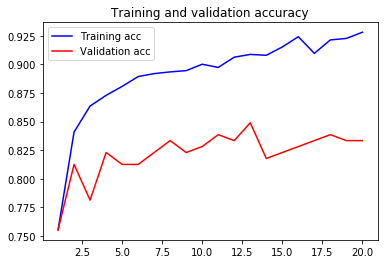

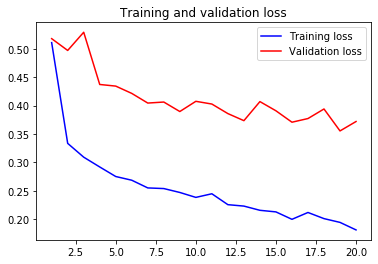

In [433]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model evaluation

In [434]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(test_generator)
print('test loss, test acc:', results)


# Evaluate on test data
15/15 [==============================] - 6s 407ms/step - loss: 0.3826 - accuracy: 0.8259
test loss, test acc: [0.38257479667663574, 0.8259023427963257]


In [435]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.round(predictions)

In [436]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [437]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.71      0.85      0.77       164
   PNEUMONIA       0.91      0.81      0.86       307

    accuracy                           0.83       471
   macro avg       0.81      0.83      0.82       471
weighted avg       0.84      0.83      0.83       471



In [438]:
y_true = test_generator.classes
y_pred = predictions > 0.5

In [439]:
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix/data
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [440]:
Y_pred = model.predict(test_generator, len(df_test) // 32)
y_pred = np.round(Y_pred)
cm = confusion_matrix(test_generator.classes, y_pred)

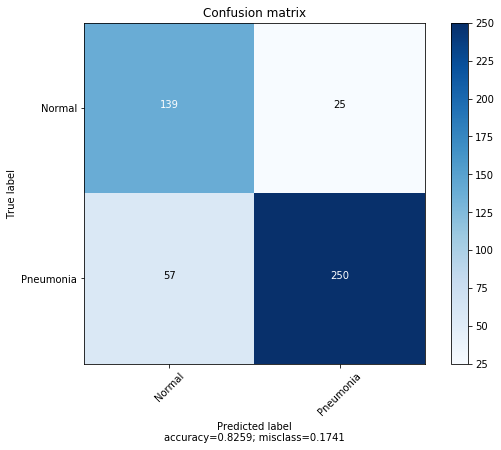

In [441]:
plot_confusion_matrix(cm, ['Normal', 'Pneumonia'], normalize=False)

In [442]:
test_generator.class_indices.keys()

dict_keys(['NORMAL', 'PNEUMONIA'])

In [443]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}